# Обучение собственного потенциала на основе машинного обучения

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch 
import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from scipy.optimize import minimize, differential_evolution

from numba import njit
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from IPython.display import clear_output


Для начала попытается подобрать параметры для какого-нибудь парного потенциала, чтобы понять, правильно ли мы используем данные.

In [110]:
def Buckingham(r, A, B, C):
    return A * np.exp( -B * r) - C / r ** 6

def Buckingham_F(r_i, r, A, B, C):
    return A * B * np.exp( - B * r) / r * r_i + 6 * C / r ** 8 * r_i

def lj(r, eps, sigma):
    return 4 * eps * ((sigma / r) ** 12 - (sigma / r) ** 6)

def lj_F(r_i, r, eps, sigma):
    return 24 * eps * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r ** 2 * r_i


Импортируем позиции атомов, энергии, а также суперячейку для каждой конфигурации, чтобы потом получить ghost атомы

In [3]:
with open('train_Al.cfg') as f:
    add_line = False
    add_energy = False
    add_supercell = False
    
    data = []
    frame = []
    energies = []
    supercell = []
    supercells = []
    
    for line in f.readlines():
        
        if 'Energy'      in line: 
            add_line = False
            data.append(frame)
            frame = []
            
        if 'AtomData:'   in line:
            add_supercell = False
            supercells.append(supercell)
            supercell = []
            
        if add_line: 
            frame.append(list(map(float, line.split() ) ))
            
        if add_supercell:
            supercell.append(list(map(float, line.split())))    
        
        if add_energy: 
            energies.append(float(line))
            add_energy = False
        
        if 'Energy'      in line: add_energy = True
        if 'Supercell'   in line: add_supercell = True
        if 'AtomData:'   in line: add_line = True
            
energies = np.array(energies)
data = np.array(data)       
supercells = np.array(supercells) 

In [5]:
def add_ghost_atoms(positions, lattice, cutoff):
    """
    Добавляет "призрачные" атомы для реализации PBC.

    positions: np.ndarray
        Координаты атомов (N, 3).
    lattice: np.ndarray
        Матрица суперячейки (3, 3).
    cutoff: float
        Радиус отсечения.

    Returns:
        np.ndarray: Новые позиции атомов с учетом "призрачных" атомов.
    """

    # Храним все новые атомные позиции
    ghost_positions = []
    

    # Вычисляем пределы, до которых нужно расширить ячейку
    periodic_shifts = []
    for i in range(-1, 2):  # -1, 0, 1
        for j in range(-1, 2):
            for k in range(-1, 2):
                if (i, j, k) != (0, 0, 0):  # Не включаем саму ячейку
                    periodic_shifts.append(i * lattice[0] + j * lattice[1] + k * lattice[2])

    # Добавляем "призрачные" атомы
    for shift in periodic_shifts:
        for pos in positions:
            shifted_pos = pos + shift

            # Проверяем, находится ли сдвинутая позиция в пределах отсечения
            dist_to_original = np.linalg.norm(positions - shifted_pos, axis=1)
            if np.any(dist_to_original < cutoff) * np.any(dist_to_original > 1e-1):
                ghost_positions.append(shifted_pos)

    return np.array(ghost_positions)


In [6]:
ghosts = []

for frame, supercell in tqdm(zip(data, supercells)):
    ghosts.append(add_ghost_atoms(frame[:,2:5], supercell, cutoff=5))


2185it [02:49, 12.91it/s]


In [461]:
ghosts[0]

array([[-4.04377100e+00,  0.00000000e+00, -9.99999999e-07],
       [-2.02187100e+00,  0.00000000e+00, -2.02187100e+00],
       [-2.02187100e+00, -2.02188000e+00, -9.99999999e-07],
       ...,
       [ 1.21319710e+01,  1.61760800e+01,  4.04411000e+00],
       [ 1.21319710e+01,  1.61760800e+01,  8.08786000e+00],
       [ 1.21319710e+01,  1.41538400e+01,  1.41538410e+01]])

In [462]:
energy_scale = np.std(energies)
force_scale = np.std(np.linalg.norm(data[:,:,-3:], axis=-1))
energy_scale, force_scale

(4.502818638163145, 0.510708344552198)

In [463]:
def compute_forces_and_energies(data, ghosts, A, B, cutoff_radius=5.0):
    """
    Рассчитывает силы и энергии с учетом уже добавленных мнимых атомов.

    Args:
        data: массив атомов (реальные), shape = (n_real_atoms, 3).
        ghosts: массив мнимых атомов, shape = (n_ghost_atoms, 3).
        A, B: параметры для потенциала Леннард-Джонса.
        cutoff_radius: радиус отсечки для расчета.

    Returns:
        forces: массив сил для реальных атомов, shape = (n_real_atoms, 3).
        total_energy: суммарная энергия системы.
    """
    
    n_atoms = len(data)  # Число реальных атомов
    forces = np.zeros((n_atoms, 3))  # Силы для реальных атомов
    total_energy = 0.0  # Суммарная энергия системы

    # Объединяем реальные и мнимые атомы в один массив
    all_atoms = np.vstack([data, ghosts])

    # Радиус отсечки в квадрате
    cutoff_squared = cutoff_radius ** 2

    # Цикл по реальным атомам
    for i in range(n_atoms):
        for j in range(len(all_atoms)):
            if i == j:
                continue  # Пропускаем сам себя

            # Разница координат
            delta = all_atoms[j] - data[i]

            

            # Квадрат расстояния
            squared_distance = np.dot(delta, delta)
            if squared_distance < 1e-4:
                # continue
                print(i, j, squared_distance)
                
            if squared_distance < cutoff_squared:
                
                r = np.sqrt(squared_distance)
                total_energy += lj(r, A, B)

                
                force = lj_F(delta, r, A, B)
                forces[i] += force  # Обновляем силу только для реальных атомов

    return forces, total_energy





def predict(data, ghosts, A, B):
    predicted_energies = []
    predicted_forces = []

    for frame, ghost in zip(data, ghosts):
        forces, energy = compute_forces_and_energies(frame, ghost, A, B)
        predicted_forces.append(forces)
        predicted_energies.append(energy)

    predicted_energies = np.array(predicted_energies)
    predicted_forces = np.array(predicted_forces)

    return predicted_energies, predicted_forces


def loss_function(data, ghosts, true_energies, true_forces, A, B):
    """
    Вычисляет значение функции потерь для заданных параметров потенциала.

    Args:
        data: список данных (кадры, каждый кадр - массив частиц).
        true_energies: массив истинных энергий, shape = (n_frames,).
        true_forces: массив истинных сил, shape = (n_frames, n_particles, 3).
        A, B, C: параметры потенциала.

    Returns:
        loss: значение функции потерь (скаляр).
    """
    
    predicted_energies, predicted_forces = predict(data, ghosts, A, B)

    # MSE для энергий
    energy_loss = np.mean((predicted_energies - true_energies) ** 2)
    # MSE для сил
    force_loss = np.mean((predicted_forces - true_forces) ** 2)

    # Итоговая функция потерь
    loss = (energy_loss / energy_scale) + (force_loss / force_scale)
    return loss

### Torch функции

In [ ]:

# PyTorch-версия функции потерь
def loss_function_torch(data, true_energies, true_forces, A, B, C, energy_scale=1.0, force_scale=1.0):
    predicted_energies = []
    predicted_forces = []

    for frame in data:
        forces, energy = compute_forces_and_energies_torch(frame, A, B, C)
        predicted_forces.append(forces)
        predicted_energies.append(energy)

    predicted_energies = torch.stack(predicted_energies)
    predicted_forces = torch.stack(predicted_forces)

    # MSE для энергий
    energy_loss = torch.mean((predicted_energies - true_energies) ** 2)
    # MSE для сил
    force_loss = torch.mean((predicted_forces - true_forces) ** 2)

    # Итоговый лосс
    loss = (energy_loss / energy_scale) + (force_loss / force_scale)
    return loss

def Buckingham(r, A, B, C):
    # r - расстояние (тензор PyTorch), A, B, C - параметры (тензоры PyTorch)
    return A * torch.exp(-B * r) - C / (r ** 6)

def Buckingham_F(delta, r, A, B, C):
    # delta - вектор смещения [dx, dy, dz] (тензор PyTorch)
    # r - расстояние между частицами (тензор PyTorch)
    coefficient = -A * B * torch.exp(-B * r) + 6 * C / (r ** 7)
    # print(coefficient)
    # print(delta)
    # print(coefficient * delta)
    return coefficient * delta  # Сила в формате [Fx, Fy, Fz]


# PyTorch-версия расчёта сил и энергий
def compute_forces_and_energies_torch(data, A, B, C, cutoff_radius=8.0, box_size=12.131971):
    # Убедимся, что A, B, C — это тензоры
    A = torch.tensor(A, dtype=torch.float32, device='cpu') if not isinstance(A, torch.Tensor) else A
    B = torch.tensor(B, dtype=torch.float32, device=A.device) if not isinstance(B, torch.Tensor) else B
    C = torch.tensor(C, dtype=torch.float32, device=A.device) if not isinstance(C, torch.Tensor) else C

    half_box_size = box_size / 2
    squared_cutoff = cutoff_radius ** 2

    n = len(data)
    forces = torch.zeros((n, 3), dtype=torch.float32, device=A.device)  # Инициализация сил
    energy = torch.tensor(0.0, dtype=torch.float32, device=A.device)  # Потенциальная энергия системы

    for i in range(n - 1):
        for j in range(i + 1, n):
            # Извлекаем только координаты x, y, z
            delta = data[i, 2:5] - data[j, 2:5]
            delta = delta - box_size * torch.round(delta / box_size)  # Учёт PBC
            squared_distance = torch.sum(delta ** 2)

            if squared_distance < squared_cutoff:
                r = torch.sqrt(squared_distance)
                energy += Buckingham(r, A, B, C)
                force = Buckingham_F(delta, r, A, B, C)  # Сила [Fx, Fy, Fz]
                forces[i] += force
                forces[j] -= force




    return forces, energy


### Подбор параметров

In [274]:
forces = data[:,:,5:]
positions = data[:,:,2:5]

In [464]:
idxs = np.random.choice(len(data), 50, replace=False)
data_cut = data[idxs]
forces_cut = forces[idxs]
energies_cut = energies[idxs]
pos_cut = positions[idxs]
ghosts_cut = [ghosts[idx] for idx in idxs]

In [283]:
supercells[10]

array([[ 1.2136721e+01, -1.0570000e-02, -1.2237000e-02],
       [ 0.0000000e+00,  1.2138383e+01, -2.8500000e-04],
       [-0.0000000e+00,  0.0000000e+00,  1.2132020e+01]])

In [465]:
%%time
pred_en, pred_forces = predict(pos_cut, ghosts_cut, 0.4, 2.55)
pred_en

CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.12 s


array([-490.0910994 , -478.56010072, -478.88680508, -527.71788544,
       -504.29520963, -469.49854123, -568.4377753 , -465.63463967,
       -497.17346284, -483.82278261, -547.31166501, -470.736462  ,
       -466.32120333, -468.38840442, -494.87523862, -568.73691936,
       -472.1830104 , -505.14953462, -487.61455525, -487.13610925,
       -540.66007742, -492.30916676, -454.09601942, -590.75841806,
       -499.10154061, -464.97420547, -473.91718948, -477.18888221,
       -489.0243506 , -473.46846786, -468.12595196, -493.29233677,
       -488.74854182, -489.15089596, -470.03678776, -493.12675346,
       -469.16928892, -496.04747316, -527.48470292, -496.33667399,
       -470.83197385, -472.19664876, -474.38298375, -512.16002186,
       -502.50190003, -544.54389897, -492.97565893, -477.64411974,
       -510.50777986, -463.81706993])

CPU times: user 3.05 s, sys: 1.95 ms, total: 3.05 s
Wall time: 3.05 s


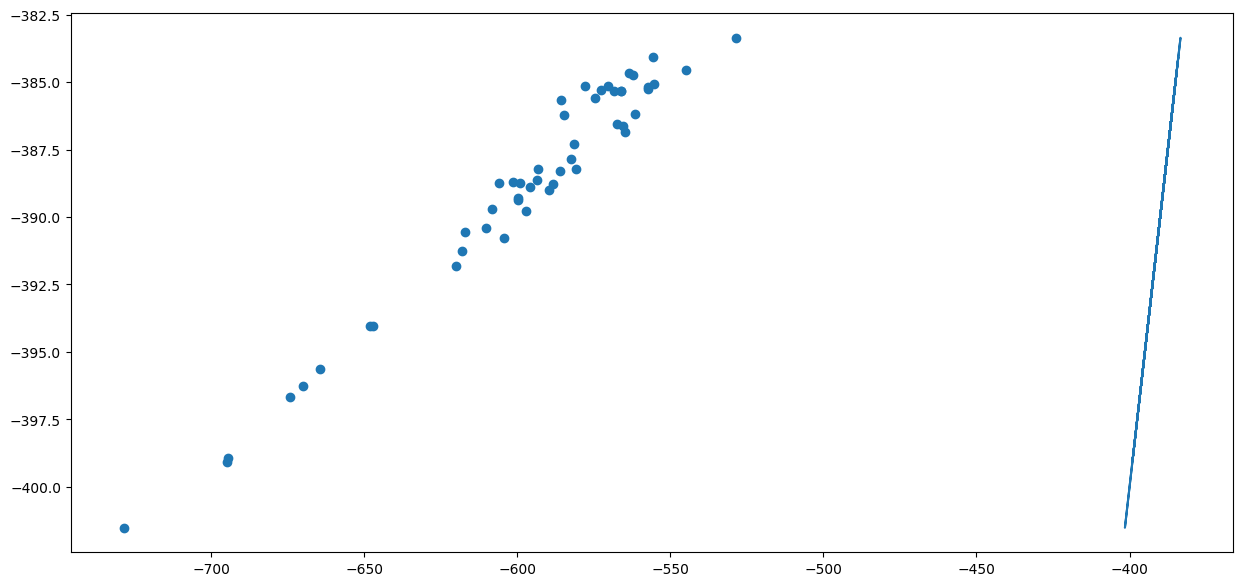

In [466]:
%%time
pred_en, pred_forces = predict(pos_cut, ghosts_cut, 0.5, 2.6)
plt.figure(figsize=(15, 7))
plt.plot(energies_cut, energies_cut)
plt.scatter(pred_en, energies_cut)


In [471]:
optimization_log = []

def loss_for_scipy(params):
    A, B= params
    loss = loss_function(pos_cut, ghosts_cut, energies_cut, forces_cut, A, B)
    # optimization_log.append((A, B, C, loss))
    return loss

# Начальные значения параметров
initial_guess = [0.45734527, 2.19995431]

# Ограничения на параметры (если нужно)
bounds = [(0.1, 10.0), (0.1, 10.0), (0.1, 10.0)]  # Например, от 0.1 до 10

def callback(params):
    A, B, C = params
    loss = optimization_log[-1][-1]  # Последний посчитанный loss
    # print(f"Iter {len(optimization_log) - 1:4d}   A: {A:.6f}   B: {B:.6f}   C: {C:.6f}   loss: {loss:.6f}", flush=True)
    


result = minimize(
    loss_for_scipy,
    x0=initial_guess,
    method='L-BFGS-B',  # Или другой метод: 'Powell', 'L-BFGS-B', etc.
    options={'maxiter': 30, 'disp': True},
    
)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43610D+01    |proj g|=  2.07563D+02


 This problem is unconstrained.



At iterate    1    f=  4.43004D+01    |proj g|=  5.17055D+01

At iterate    2    f=  4.42970D+01    |proj g|=  6.51855D+00

At iterate    3    f=  4.42947D+01    |proj g|=  2.17771D+01

At iterate    4    f=  4.42851D+01    |proj g|=  5.05647D+01

At iterate    5    f=  4.42448D+01    |proj g|=  1.04332D+02

At iterate    6    f=  4.40407D+01    |proj g|=  2.06445D+01

At iterate    7    f=  4.40280D+01    |proj g|=  1.44754D+02

At iterate    8    f=  4.40177D+01    |proj g|=  8.67595D+01

At iterate    9    f=  4.40081D+01    |proj g|=  6.69271D+01

At iterate   10    f=  4.39437D+01    |proj g|=  1.63027D+01

At iterate   11    f=  4.39050D+01    |proj g|=  8.33267D+01

At iterate   12    f=  4.38841D+01    |proj g|=  1.26027D+02

At iterate   13    f=  4.38432D+01    |proj g|=  5.57368D+01

At iterate   14    f=  4.38160D+01    |proj g|=  9.15050D+01

At iterate   15    f=  4.37849D+01    |proj g|=  1.13681D+01

At iterate   16    f=  4.37749D+01    |proj g|=  5.31146D+01

At iter

In [472]:
result.x

array([0.60282039, 2.07351262])

In [102]:
class DECallback:
    def __init__(self):
        self.iterations = 0  # Счетчик итераций
        self.history = []    # Сохранение истории
        print(f"{'Iter':<6} {'Params':<30} {'Loss':<15}")
        print("-" * 50)

    def __call__(self, xk, convergence):
        """
        Callback вызывается на каждой итерации оптимизации.
        xk: Текущая точка (параметры).
        convergence: Оценка сходимости (чем меньше, тем лучше).
        """
        self.iterations += 1
        loss = loss_for_scipy(xk)  # Рассчитываем значение функции потерь
        self.history.append((self.iterations, xk, loss))
        
        # Печать информации
        params_str = ", ".join(f"{xi:.5f}" for xi in xk)
        print(f"{self.iterations:<6} {params_str:<30} {loss:<15.5f}")
        
        # Можно возвращать True для остановки, если требуется.
        return False


In [ ]:
# Инициализация callback
callback = DECallback()
bounds = [(0.1, 20000.0), (0.1, 10.0), (0.1, 200.0)]

# Запуск оптимизации с differential_evolution
result = differential_evolution(
    loss_for_scipy,
    bounds=bounds,
    callback=callback,
    strategy='best1bin',
    maxiter=15,
    popsize=15,
    tol=1e-3,
    disp=True,
    updating='deferred',
    polish=False,
    workers=4
)

# Итоговая история оптимизации
print("\nИстория оптимизации:")
for iter_num, params, loss in callback.history:
    print(f"Итерация {iter_num}: Параметры = {params}, Loss = {loss}")


In [ ]:
bounds = [(0.1, 20000.0), (0.1, 10.0), (0.1, 200.0)]

# Глобальная оптимизация
result_global = differential_evolution(loss_for_scipy, bounds, disp=True, maxiter=2)
print("Глобальная оптимизация: ", result_global)

In [473]:
print(result)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 43.71993364179907
        x: [ 6.028e-01  2.074e+00]
      nit: 30
      jac: [-1.174e+00 -1.673e+00]
     nfev: 123
     njev: 41
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


Значения $\sigma$ и $\varepsilon$ получились довольно близко к справочным. Отсюда делаем вывод, что импорт данных и учет периодических гран условий были выполнены успешно.

CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 2.99 s


0.3391604902954418

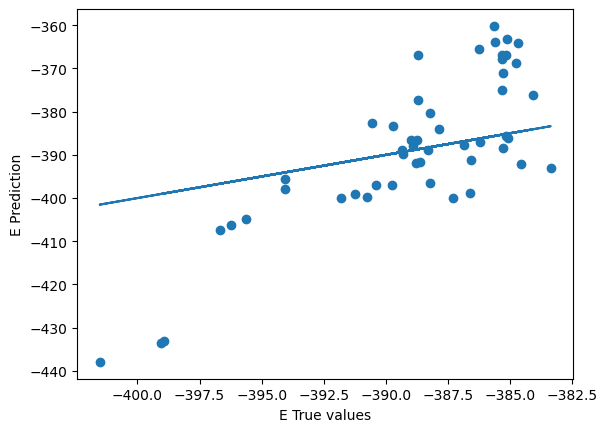

In [474]:

%%time

pred_en, pred_forces = predict(pos_cut, ghosts_cut, *result.x)
# loss_function(data_cut, true_energies=energies_cut, true_forces=forces_cut, *result.x)
plt.plot(energies_cut, energies_cut)
plt.scatter(energies_cut, pred_en)
plt.xlabel('E True values')
plt.ylabel('E Prediction')
r2_score(pred_en, energies_cut)


### Создание дескрипторов

Сначала попробуем создать простейшую модель вида:

![](./images/model1.png)

Здесь цвета обозначают типы атомов, однако у меня пока только 1

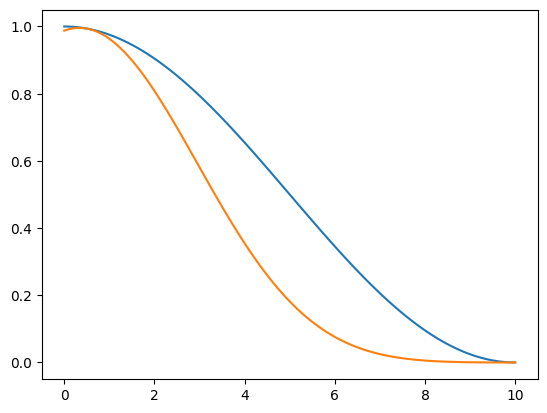

In [16]:
def f_cut(r, cutoff=5.0): 
    return 0.5 * (np.cos(np.pi * r / cutoff) + 1) * (r <= cutoff)
    

def G_rad_ij(r, eta=0.05, cutoff=5.0, r_s=0.5):
    return np.exp( - eta * (r - r_s) ** 2) * f_cut (r, cutoff=cutoff)

grid = np.linspace(0, 10, 100)
plt.plot(grid, f_cut(grid, cutoff=10))
plt.plot(grid, G_rad_ij(grid, cutoff=10));

In [14]:
def get_descriptor(pos, ghosts, cutoff=5.0):

    n_atoms = len(pos)  # Число реальных атомов
    # Объединяем реальные и мнимые атомы в один массив
    all_atoms = np.vstack([pos, ghosts])

    # Радиус отсечки в квадрате
    cutoff_squared = cutoff ** 2
    G_rad = []
    # Цикл по реальным атомам
    for i in range(n_atoms):
        G_rad_i = 0
        for j in range(len(all_atoms)):
            if i == j:
                continue  # Пропускаем сам себя

            delta = all_atoms[j] - pos[i]
            squared_distance = np.dot(delta, delta)
            
            
            if squared_distance < cutoff_squared:
                G_rad_i += G_rad_ij(squared_distance ** 0.5, cutoff=cutoff)
        G_rad.append(G_rad_i)
    
    return np.array(G_rad)
        

In [17]:
G = []

for pos, ghost in tqdm(zip(data[:,:,2:5], ghosts)):
    G.append(get_descriptor(pos, ghost, cutoff=10.0))
    
G = np.array(G)

2185it [08:10,  4.45it/s]


In [477]:
G.shape

(2185, 108)

In [357]:
energies.shape

(2185,)

In [19]:
df = pd.DataFrame(G, columns=[i for i in range(108)])
# df.to_csv('descriptors_0.03_0.5_cutoff_10.csv', index=False)
# df = pd.read_csv('descriptors.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,15.893187,15.892598,16.393688,16.393683,16.393497,16.453354,16.880502,16.841272,16.453249,16.393686,...,16.453230,16.393694,17.205169,17.205327,16.918025,16.841281,17.222055,17.186192,16.880536,16.880527
1,15.855765,16.443065,16.406946,16.181007,16.365113,16.815927,16.805385,17.185161,16.176046,16.679332,...,17.057680,16.128605,17.231591,17.205654,17.201909,17.069178,17.232756,17.119881,17.048869,17.040082
2,15.755877,16.401612,16.405039,16.366011,16.364304,16.837034,16.817362,17.183454,16.190667,16.403977,...,17.054516,16.160949,17.229935,17.204546,17.201036,17.065419,17.232732,17.141670,17.049018,17.039152
3,15.753140,16.399408,16.381128,16.365474,16.361045,16.835521,16.814826,17.181092,16.177503,16.402715,...,17.068291,16.155559,17.229478,17.214436,17.199226,17.134538,17.231695,17.139583,17.047192,17.038592
4,15.755200,16.236153,16.270206,16.364975,16.063737,16.649139,16.626919,17.138238,16.146766,16.365596,...,17.064031,16.326486,17.226277,17.215655,17.210702,17.154620,17.232583,17.156613,17.110037,17.157599


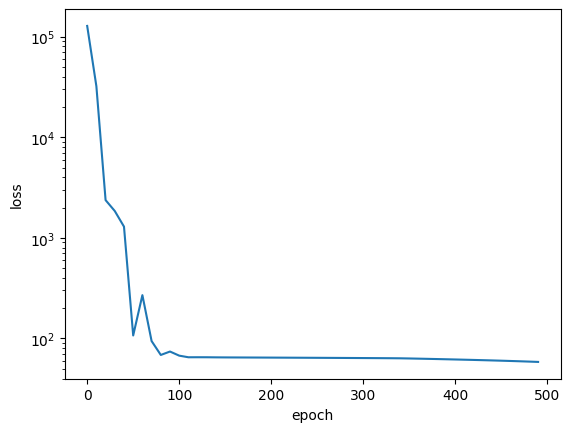

In [483]:


X_train, X_test, y_train, y_test = train_test_split(G, energies, train_size=0.8, random_state=42)

# Простая модель перцептрона
class EnergyPredictor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, descriptors):
        return self.fc(descriptors)

# Функция потерь
def loss_fn(predicted_energies, total_energy_targets, atom_counts):
    predicted_totals = torch.zeros(len(total_energy_targets), device=predicted_energies.device)
    start_idx = 0
    for i in range(len(total_energy_targets)):  # len(total_energy_targets) = количество конфигураций
        predicted_totals[i] = predicted_energies[start_idx:start_idx + atom_counts].sum()
        start_idx += atom_counts
    return ((predicted_totals - total_energy_targets) ** 2).mean()

# Параметры данных
num_configurations = len(X_train)
input_dim = 1  # Длина дескриптора
atom_counts = 108  # Число атомов в каждой конфигурации

# Преобразование данных
descriptors = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
total_energies = torch.tensor(y_train, dtype=torch.float32)

# Модель и оптимизатор
model = EnergyPredictor(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение
max_epochs = 500
losses = []
epochs = []

for epoch in range(max_epochs):
    optimizer.zero_grad()
    predicted_energies = model(descriptors).squeeze()
    
    loss = loss_fn(predicted_energies, total_energies, atom_counts)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        epochs.append(epoch)
        losses.append(loss.item())
        clear_output()
        plt.plot(epochs, losses)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.pause(0.01)
       



In [ ]:
with torch.no_grad():
    predicted_energies = model(descriptors).squeeze()
    start_idx = 0
    for i in range(len(atom_counts)):
        atom_energies = predicted_energies[start_idx:start_idx + atom_counts[i]]
        print(f"Configuration {i} - Predicted total energy: {atom_energies.sum().item()}, True total energy: {total_energies[i].item()}")
        start_idx += atom_counts[i]


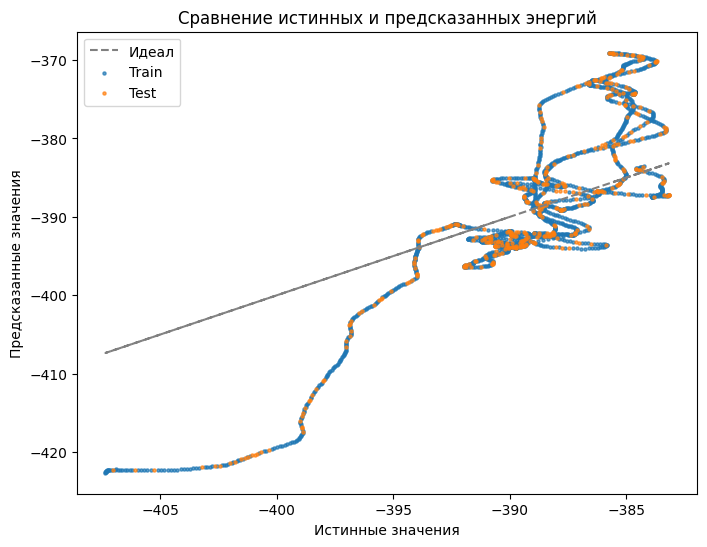

In [496]:
with torch.no_grad():
    # Предсказания на тренировочных данных
    descriptors_train = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_train = model(descriptors_train).squeeze()
    
    start_idx = 0
    pred_train = []
    for i in range(len(X_train)):
        pred_train.append(predicted_energies_train[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

    # Предсказания на тестовых данных
    descriptors_test = torch.tensor(X_test.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_test = model(descriptors_test).squeeze()
    
    start_idx = 0
    pred_test = []
    for i in range(len(X_test)):
        pred_test.append(predicted_energies_test[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(y_train, y_train, color='gray', linestyle='--', label='Идеал')  # Линия идеального предсказания
plt.scatter(y_train, pred_train, s=5, label='Train', alpha=0.7)
plt.scatter(y_test, pred_test, s=5, label='Test', alpha=0.7)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.title('Сравнение истинных и предсказанных энергий')
plt.show()


Обычно ожидается увидеть разброс, а здесь мы видем какую-то кривую. Посмотрим, что происходит на пониженной размерности.

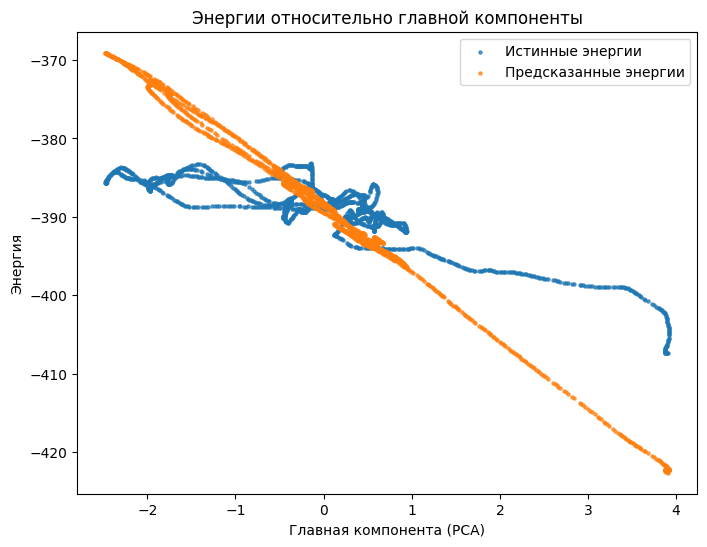

In [507]:
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)  # Преобразуем в одномерное представление

# Визуализация предсказаний относительно главной компоненты
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca, y_train, s=5, label='Истинные энергии', alpha=0.7)
plt.scatter(X_train_pca, pred_train, s=5, label='Предсказанные энергии', alpha=0.7)

plt.xlabel('Главная компонента (PCA)')
plt.ylabel('Энергия')
plt.legend()
plt.title('Энергии относительно главной компоненты')
plt.show()

Модель предсказывает практически линию. То есть, вероятно, дело не в дескрипторах, а в простоте модели. Перцептрон предсказывает слишком линеаризованно.

In [510]:
pca = PCA(n_components=10)
pca.fit(X_train)
print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_)
print("Суммарная доля дисперсии:", pca.explained_variance_ratio_.sum())


Доля объяснённой дисперсии: [0.38676272 0.06711356 0.06163782 0.04695219 0.04053492 0.03751598
 0.03402716 0.02862963 0.02649237 0.02479322]
Суммарная доля дисперсии: 0.7544595713956727


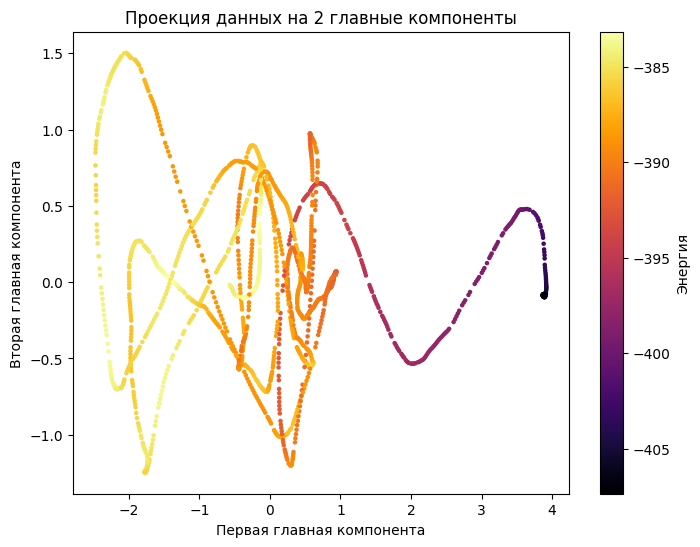

In [513]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='inferno', s=5)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Энергия')
plt.title('Проекция данных на 2 главные компоненты')
plt.show()


Ещё такую зависимость также можно объяснить большой схожестью данных в датасете. То есть конфигурации были, скорее всего получены молекулярной динамикой, и поэтому среди них есть множество похожих друг на друга.

Создается впечатление, что перцептрон обучился предсказывать энергию лишь примерно по первой главной компоненте с небольшим изменением направления. В сторону её уменьшения увеличивается энергия.

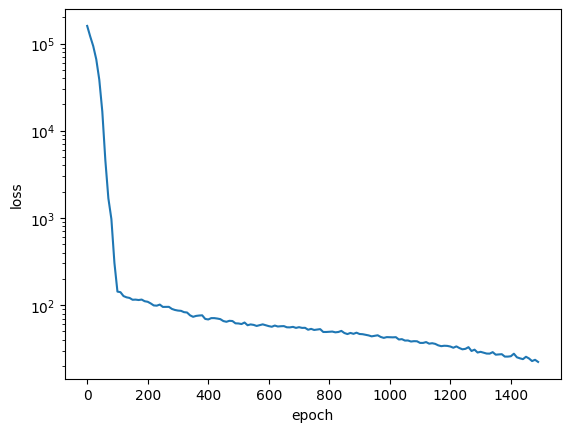

In [515]:


X_train, X_test, y_train, y_test = train_test_split(G, energies, train_size=0.8, random_state=42)

# Простая модель перцептрона
class EnergyPredictor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),          
            nn.BatchNorm1d(128),                
            nn.ReLU(),                          
            nn.Dropout(0.2),                    
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)   
        )

    def forward(self, descriptors):
        return self.fc(descriptors)

# Функция потерь
def loss_fn(predicted_energies, total_energy_targets, atom_counts):
    predicted_totals = torch.zeros(len(total_energy_targets), device=predicted_energies.device)
    start_idx = 0
    for i in range(len(total_energy_targets)):  # len(total_energy_targets) = количество конфигураций
        predicted_totals[i] = predicted_energies[start_idx:start_idx + atom_counts].sum()
        start_idx += atom_counts
    return ((predicted_totals - total_energy_targets) ** 2).mean()

# Параметры данных
num_configurations = len(X_train)
input_dim = 1  # Длина дескриптора
atom_counts = 108  # Число атомов в каждой конфигурации

# Преобразование данных
descriptors = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
total_energies = torch.tensor(y_train, dtype=torch.float32)

# Модель и оптимизатор
model = EnergyPredictor(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение
max_epochs = 1500
losses = []
epochs = []

for epoch in range(max_epochs):
    optimizer.zero_grad()
    predicted_energies = model(descriptors).squeeze()
    
    loss = loss_fn(predicted_energies, total_energies, atom_counts)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        epochs.append(epoch)
        losses.append(loss.item())
        clear_output()
        plt.plot(epochs, losses)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.pause(0.01)
       



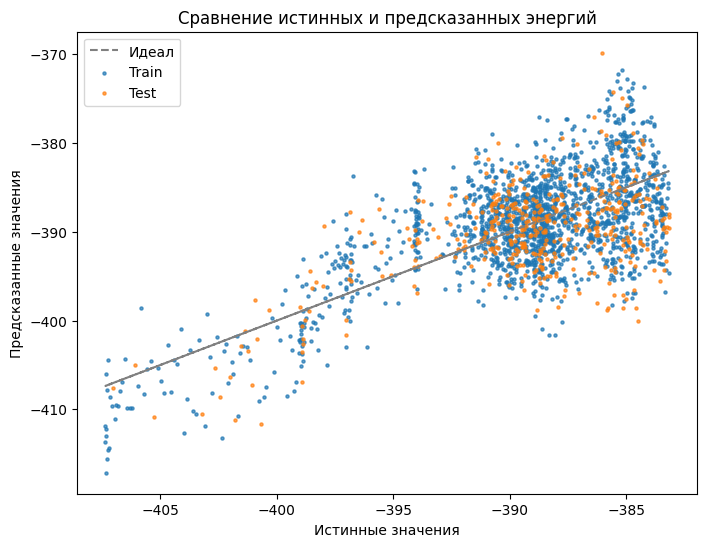

In [518]:
with torch.no_grad():
    # Предсказания на тренировочных данных
    descriptors_train = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_train = model(descriptors_train).squeeze()
    
    start_idx = 0
    pred_train = []
    for i in range(len(X_train)):
        pred_train.append(predicted_energies_train[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

    # Предсказания на тестовых данных
    descriptors_test = torch.tensor(X_test.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_test = model(descriptors_test).squeeze()
    
    start_idx = 0
    pred_test = []
    for i in range(len(X_test)):
        pred_test.append(predicted_energies_test[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(y_train, y_train, color='gray', linestyle='--', label='Идеал')  # Линия идеального предсказания
plt.scatter(y_train, pred_train, s=5, label='Train', alpha=0.7)
plt.scatter(y_test, pred_test, s=5, label='Test', alpha=0.7)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.title('Сравнение истинных и предсказанных энергий')
plt.show()
# print("R2_score train:", r2_score(y_train, pred_train))
# print("R2_score test:", r2_score(y_test, pred_test))

Вооооо, это уже мне нравится больше. Тренд лосса тоже класс, лучше обучить на большее число эпох

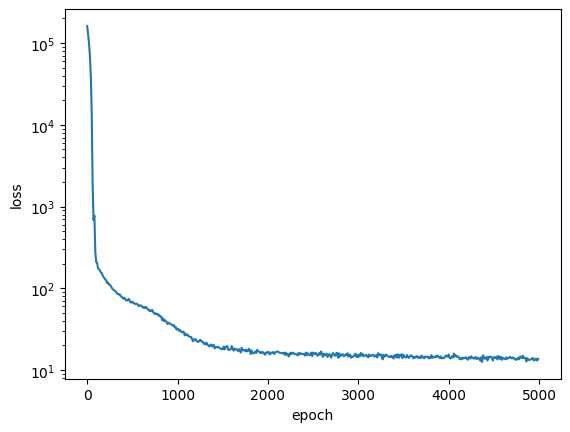

In [520]:

# Функция потерь
def loss_fn(predicted_energies, total_energy_targets, atom_counts):
    predicted_totals = torch.zeros(len(total_energy_targets), device=predicted_energies.device)
    start_idx = 0
    for i in range(len(total_energy_targets)):  # len(total_energy_targets) = количество конфигураций
        predicted_totals[i] = predicted_energies[start_idx:start_idx + atom_counts].sum()
        start_idx += atom_counts
    return ((predicted_totals - total_energy_targets) ** 2).mean()

# Параметры данных
num_configurations = len(X_train)
input_dim = 1  # Длина дескриптора
atom_counts = 108  # Число атомов в каждой конфигурации

# Преобразование данных
descriptors = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
total_energies = torch.tensor(y_train, dtype=torch.float32)

# Модель и оптимизатор
model = EnergyPredictor(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение
max_epochs = 5000
losses = []
epochs = []

for epoch in range(max_epochs):
    optimizer.zero_grad()
    predicted_energies = model(descriptors).squeeze()
    
    loss = loss_fn(predicted_energies, total_energies, atom_counts)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        epochs.append(epoch)
        losses.append(loss.item())
        clear_output()
        plt.plot(epochs, losses)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.pause(0.01)
       



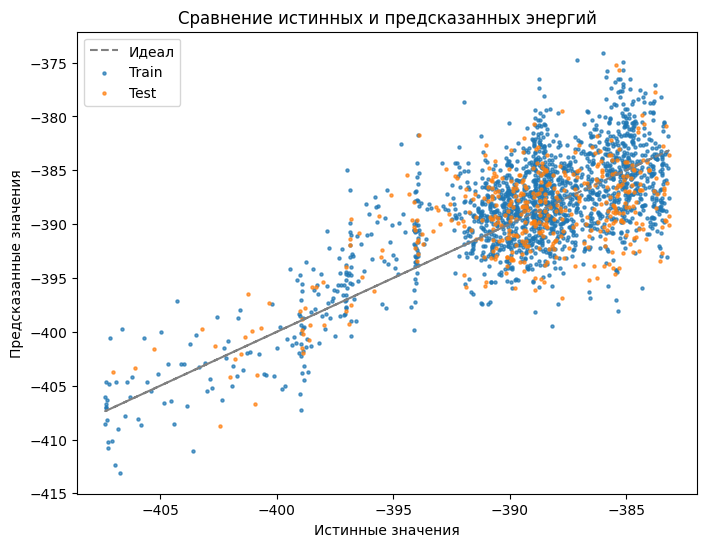

R2_score train: 0.33428739688184594
R2_score test: 0.21582620630884897


In [522]:
with torch.no_grad():
    # Предсказания на тренировочных данных
    descriptors_train = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_train = model(descriptors_train).squeeze()
    
    start_idx = 0
    pred_train = []
    for i in range(len(X_train)):
        pred_train.append(predicted_energies_train[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

    # Предсказания на тестовых данных
    descriptors_test = torch.tensor(X_test.flatten().reshape(-1, 1), dtype=torch.float32)
    predicted_energies_test = model(descriptors_test).squeeze()
    
    start_idx = 0
    pred_test = []
    for i in range(len(X_test)):
        pred_test.append(predicted_energies_test[start_idx:start_idx + atom_counts].sum().item())
        start_idx += atom_counts

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(y_train, y_train, color='gray', linestyle='--', label='Идеал')  # Линия идеального предсказания
plt.scatter(y_train, pred_train, s=5, label='Train', alpha=0.7)
plt.scatter(y_test, pred_test, s=5, label='Test', alpha=0.7)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.title('Сравнение истинных и предсказанных энергий')
plt.show()
print("R2_score train:", r2_score(y_train, pred_train))
print("R2_score test:", r2_score(y_test, pred_test))

Ну, для своего собственного потенциала, на первый раз сойдет

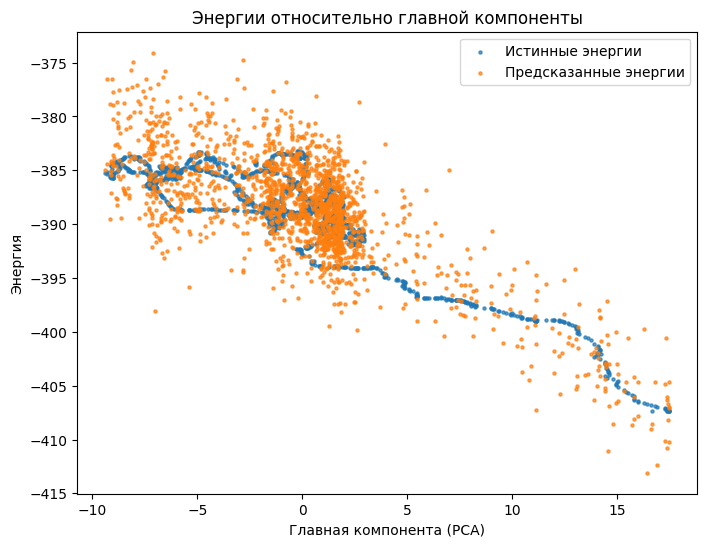

In [525]:
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)  # Преобразуем в одномерное представление

# Визуализация предсказаний относительно главной компоненты
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca, y_train, s=5, label='Истинные энергии', alpha=0.7)
plt.scatter(X_train_pca, pred_train, s=5, label='Предсказанные энергии', alpha=0.7)

plt.xlabel('Главная компонента (PCA)')
plt.ylabel('Энергия')
plt.legend()
plt.title('Энергии относительно главной компоненты')
plt.show()

In [20]:
# torch.save(model.state_dict(), 'energy_predictor.pth')
class EnergyPredictor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),          
            nn.BatchNorm1d(128),                
            nn.ReLU(),                          
            nn.Dropout(0.2),                    
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)   
        )

    def forward(self, descriptors):
        return self.fc(descriptors)
    
X_train, X_test, y_train, y_test = train_test_split(G, energies, train_size=0.8, random_state=42)

In [21]:
model = EnergyPredictor(input_dim=1)

model.load_state_dict(torch.load('energy_predictor.pth'))
model.eval()

EnergyPredictor(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [24]:
descriptors_train = torch.tensor(X_train.flatten().reshape(-1, 1), dtype=torch.float32)
total_energies = torch.tensor(y_train, dtype=torch.float32)

In [25]:
ds = torch.linspace(descriptors_train.min(), descriptors_train.max(), 10000).reshape(-1, 1)

Text(0.5, 0, 'Descriptor value')

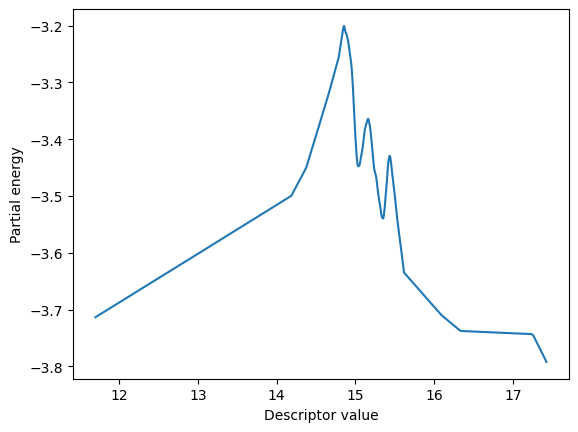

In [26]:
model.eval()

plt.plot(ds, model(ds).detach().numpy());
plt.ylabel('Partial energy')
plt.xlabel('Descriptor value')

Существует утверждение, что силы можно посчитать следующим образом:

$$F_{\mu \alpha} = - \dfrac{\partial E}{\partial R_{\mu \alpha}} = - \sum_{i=1}^{N} \dfrac{\partial E_i}{\partial R_{\mu \alpha}} = 
 - \sum_{i=1}^{N} \dfrac{\partial E_i}{\partial G_i} \dfrac{\partial G_i}{\partial R_{\mu \alpha} }$$

Не похоже, что функция $E(G)$ - особо гладкая, но вероятно производную как-то можно оценить.

In [31]:
E_partial = model(ds).detach().numpy().flatten()
E_partial

array([-3.7132833, -3.7132344, -3.7131848, ..., -3.7915635, -3.7917635,
       -3.7919626], dtype=float32)

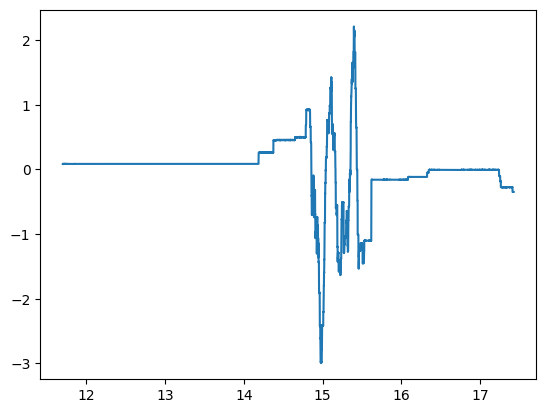

In [41]:
dE_dG = np.diff(E_partial, n=1) / np.diff(ds.flatten(), n=1)

# plt.plot(ds.flatten(), dE_dG)
dE_dG.shape, ds.flatten().shape
plt.plot(ds.flatten()[1:], dE_dG)

Звучит как глупый способ считать производную. Вероятно, в torch предусмотрен расчет градиентов

In [101]:
def get_dE_dG(G):
    gradients = []
    for G_i in G:
        grad = torch.autograd.grad(model(G_i.unsqueeze(0).unsqueeze(1)), G_i, create_graph=False)[0]
        gradients.append(grad.item())
    return np.array(gradients)

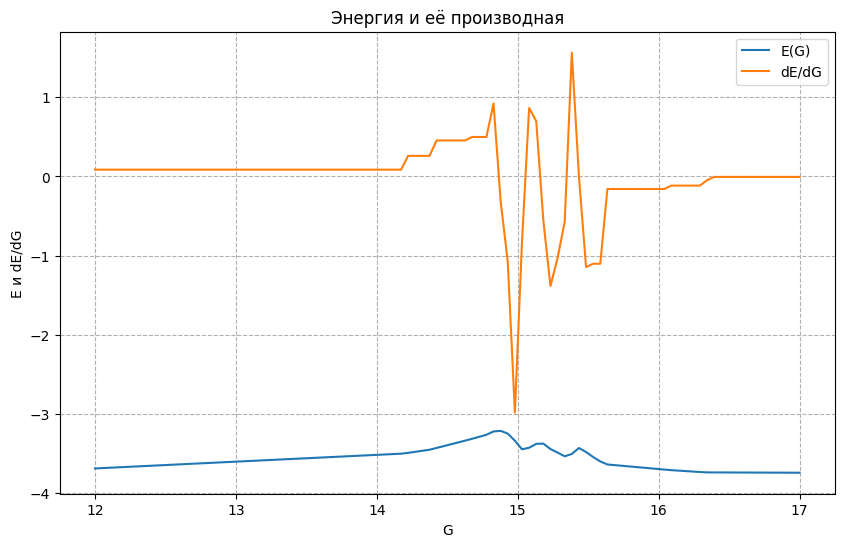

In [102]:
# Диапазон значений G_i
G_range = torch.linspace(12, 17, 100, requires_grad=True)
E_range = model(G_range.unsqueeze(1))  # Предсказания для всех G_i

# Вычисляем производные
# gradients = []
# for G_i in G_range:
#     grad = torch.autograd.grad(model(G_i.unsqueeze(0).unsqueeze(1)), G_i, create_graph=False)[0]

#     gradients.append(grad.item())
gradients = get_dE_dG(G_range)

# Построение графиков
plt.figure(figsize=(10, 6))

# График E(G)
plt.plot(G_range.detach().numpy(), E_range.detach().numpy(), label='E(G)')

# График dE/dG
plt.plot(G_range.detach().numpy(), gradients, label='dE/dG')

plt.xlabel('G')
plt.ylabel('E и dE/dG')
plt.legend()
plt.title('Энергия и её производная')
plt.grid(True, linestyle='--')
plt.show()


Значения производной уже не такие шумные

С производной $\dfrac{\partial G}{\partial R}$ придется, видимо, работать уже аналитически

$$\dfrac{\partial f_c}{\partial r} = - 0.5 \sin (\dfrac{\pi}{r_c} r) \dfrac{\pi}{r_c}$$

$$\dfrac{\partial G_{ij}}{\partial r_{ij}} = \dfrac{\partial f_c}{\partial r_{ij}} e^{- \eta (r_{ij} - r_s) ^ 2} - 2 \eta (r_{ij} - r_s) e ^ {- \eta (r_{ij} - r_s)^2} f_c(r_{ij})$$

$$\dfrac{\partial G_i}{\partial r_{ij}} = \dfrac{\partial G_{ij}}{\partial r_{ij}}$$

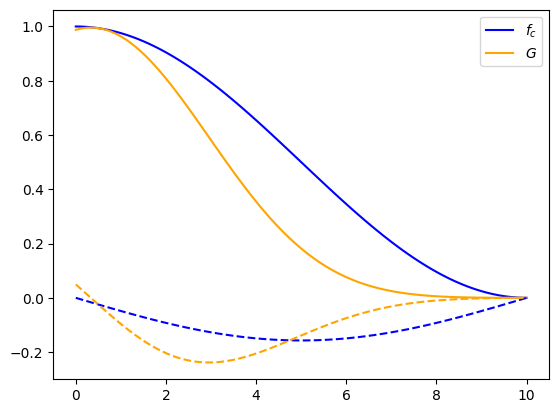

In [60]:
def f_cut_grad(r, cutoff=10.0):
    return - 0.5 * np.sin(np.pi * r / cutoff) * np.pi / cutoff

def G_rad_ij_grad(r, eta=0.05, cutoff=10.0, r_s=0.5):
    return f_cut_grad(r, cutoff=10.0) * np.exp(- eta * (r - r_s) ** 2) - 2 * eta * (r - r_s) * G_rad_ij(r=r, eta=eta, cutoff=cutoff, r_s=r_s)

grid = np.linspace(0, 10, 100)
plt.plot(grid, f_cut(grid, cutoff=10), color='b', label='$f_c$')
plt.plot(grid, G_rad_ij(grid, cutoff=10), color='orange', label='$G$')

plt.plot(grid, f_cut_grad(grid, cutoff=10), linestyle='--', c='b')
plt.plot(grid, G_rad_ij_grad(grid, cutoff=10), linestyle='--', c='orange')
plt.legend();

In [74]:
def get_descriptor_grad(pos, ghosts, cutoff=5.0):

    n_atoms = len(pos)  # Число реальных атомов
    # Объединяем реальные и мнимые атомы в один массив
    all_atoms = np.vstack([pos, ghosts])

    # Радиус отсечки в квадрате
    cutoff_squared = cutoff ** 2
    G_rad_grad = []
    # Цикл по реальным атомам
    for i in range(n_atoms):
        # print(i)
        G_rad_i = np.zeros(3)
        for j in range(len(all_atoms)):
            if i == j:
                continue  # Пропускаем сам себя

            delta = all_atoms[j] - pos[i]
            squared_distance = np.dot(delta, delta)
            
            if squared_distance < cutoff_squared:
                G_rad_i += G_rad_ij_grad(squared_distance ** 0.5, cutoff=cutoff) * delta / squared_distance ** 0.5
        G_rad_grad.append(G_rad_i)
    
    return np.array(G_rad_grad)

In [93]:
G_range.shape

torch.Size([100])

In [97]:
G_tensor = torch.tensor(G, requires_grad=True, dtype=torch.float32)
G_tensor.shape, G_tensor[0].shape

(torch.Size([2185, 108]), torch.Size([108]))

In [103]:
get_dE_dG(G_tensor[0])

array([-0.15843175, -0.15843175, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00613555,
       -0.00613555, -0.00613555, -0.00613555, -0.00613555, -0.00

In [110]:
%%time

forces0 = (get_descriptor_grad(data[:,:,2:5][0], ghosts[0], cutoff=10.0) * get_dE_dG(G_tensor[0]).reshape(-1, 1))

CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 466 ms


In [113]:
((data[:,:,5:][0] - forces0) ** 2).mean()

0.0002516962741902876

In [114]:
G_grad = []

for pos, ghost in tqdm(zip(data[:,:,2:5], ghosts)):
    G_grad.append(get_descriptor_grad(pos, ghost, cutoff=10.0))
    
G_grad = np.array(G_grad)

2185it [06:46,  5.37it/s]


In [117]:
np.save('descriptor_grad_0.03_0.5_cutoff_10.npy', G_grad)

In [ ]:
def get_forces(pos, ghosts):
    G = torch.tensor(get_descriptor(pos, ghosts, cutoff=10.0), requires_grad=True, dtype=torch.float32)
    G_grad = get_descriptor_grad(pos, ghosts, cutoff=10.0)
    dE_dG = get_dE_dG(G).reshape(-1, 1)
    
    forces = G_grad * dE_dG
    return forces

get_forces(data[:,:,2:5][0], ghosts[0])
    

In [127]:
def get_energy_and_forces(pos, ghosts):
    """
    Рассчитывает энергию и силы для текущих позиций атомов.
    
    Args:
        pos: тензор с текущими позициями атомов, shape = (n_atoms, 3).
        ghosts: ghost атомы, предварительно рассчитанные для pos.
        
    Returns:
        energy: скаляр, энергия системы.
        forces: тензор сил, shape = (n_atoms, 3).
    """
    G = torch.tensor(get_descriptor(pos, ghosts, cutoff=10.0), requires_grad=True, dtype=torch.float32)
    G_grad = get_descriptor_grad(pos, ghosts, cutoff=10.0)
    dE_dG = get_dE_dG(G).reshape(-1, 1)

    # Энергия системы (сумма парциальных энергий)
    energy = G.sum() 

    # Силы как отрицательный градиент энергии
    forces = -G_grad * dE_dG
    return energy, forces


In [129]:
def calculate_loss(pos, ghosts):
    G = torch.tensor(get_descriptor(pos, ghosts, cutoff=10.0), dtype=torch.float32)
    energy = G.sum() 
    return energy

In [131]:
initial_positions = data[:,:,2:5][0]

def calculate_ghost_atoms(pos, cutoff=10.0):
    return add_ghost_atoms(pos, supercells[0], cutoff=cutoff)

In [ ]:
# Исходные позиции атомов
pos = torch.tensor(initial_positions, requires_grad=True, dtype=torch.float32)

# Оптимизатор для обновления позиций
optimizer = torch.optim.Adam([pos], lr=0.01)  # Подберите learning rate

# Параметры оптимизации
max_steps = 1000
tolerance = 1e-5  # Условие остановки

for step in range(max_steps):
    # Пересчет ghost-атомов для текущих позиций
    ghosts = calculate_ghost_atoms(pos.detach().numpy(), cutoff=10.0)

    # Обнуление градиентов
    optimizer.zero_grad()

    # Вычисление энергии и сил
    # energy, forces = get_energy_and_forces(pos, ghosts)

    # Оцениваем градиент энергии (через силы)
    loss = calculate_loss(pos, ghosts)  # PyTorch автоматически считает градиенты для energy
    loss.backward()

    # Шаг оптимизации
    optimizer.step()

    # Вывод прогресса
    print(f"Step {step}: Energy = {energy.item()}")

    # Условие остановки
    if torch.max(torch.abs(forces)) < tolerance:
        print("Optimization converged.")
        break


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.